## Import Package

In [11]:
import matplotlib.pyplot as plt
import numpy as np

## Define function

In [12]:
class Matrix:
    def __init__(self, m, n, data):
        self.m = m
        self.n = n
        self.mat = data
        
    @classmethod
    def identity (cls, n):
        mat = [[0 for i in range(n)] for j in range(n)]
        for i in range(n):
            mat[i][i] = 1
        return Matrix(n, n, mat)
    
    @classmethod
    def zeros(cls, m, n):
        mat = [[0 for i in range(n)] for j in range(m)]
        return Matrix(m, n, mat)
        
    def mult (self, B):
        mat = [[0 for i in range(B.n)] for j in range(self.m)]
        for i in range(self.m):
            for j in range(B.n):
                for k in range(self.n):
                    mat[i][j] += self.mat[i][k] * B.mat[k][j]
        return Matrix(self.m, B.n, mat)
    
    def multScalar (self, scalar):
        mat = [[0 for i in range(self.n)] for j in range(self.m)]
        for i in range(self.m):
            for j in range(self.n):
                mat[i][j] = self.mat[i][j] * scalar
        return Matrix(self.m, self.n, mat)
                    
    def add (self, B):
        mat = [[0 for i in range(self.n)] for j in range(self.m)]
        for i in range(self.m):
            for j in range(self.n):
                mat[i][j] = self.mat[i][j] + B.mat[i][j]
        return Matrix(self.m, self.n, mat)
                
    def sub (self, B):
        mat = [[0 for i in range(self.n)] for j in range(self.m)]
        for i in range(self.m):
            for j in range(self.n):
                mat[i][j] = self.mat[i][j] - B.mat[i][j]
        return Matrix(self.m, self.n, mat)
                
    def Transpose (self):
        mat = [[0 for i in range(self.m)] for j in range(self.n)]
        for i in range(self.m):
            for j in range(self.n):
                mat[j][i] = self.mat[i][j]
        return Matrix(self.n, self.m, mat)
    
    def inverse (self):
        # Use Gauss elimination
        
        n = self.n
        
        I_n = Matrix.identity(n)
        gauss = self.mat
        for i in range(n):
            gauss[i].extend(I_n.mat[i])
            
        for i in range(n):
            for j in range(i + 1, n):
                r = gauss[j][i] / gauss[i][i]
                for k in range(i, 2 * n):
                    gauss[j][k] -= (gauss[i][k] * r)
            for j in range(2 * n - 1, i - 1, -1):
                gauss[i][j] /= gauss[i][i]
        
        for i in range(n - 1, -1, -1):
            for j in range(i - 1, -1, -1):
                r = gauss[j][i]
                for k in range(i, 2 * n):
                    gauss[j][k] -= (gauss[i][k] * r)
                
        mat = [[0 for i in range(n)] for j in range(n)]
        for i in range(n):
            for j in range(n):
                mat[i][j] = gauss[i][j + n]
        
        return Matrix(n, n, mat)

In [13]:
class Solve:
    def __init__(self, path, n, Lambda):
        self.path = path
        self.n = n
        self.Lambda = Lambda
        self.x = []
        self.y = []

    def getData (self):
        with open (self.path, 'r') as f:
            for line in f.readlines():
                data = line.replace('\n', '').split(',')
                self.x.append(float(data[0]))
                self.y.append(float(data[1]))

        self.A = Matrix.zeros(len(self.x), self.n)
        self.b = []
        for i in range(len(self.y)):
            self.b.append([])
            self.b[i].append(self.y[i])
        self.b = Matrix(len(self.y), 1, self.b)
        
        for idx, x in enumerate(self.x):
            for exp in range(self.n):
                self.A.mat[idx][exp] = x ** exp

##
def f (x, weights):
    n = len(weights)
    y = [0] * len(x)
    for idx, num in enumerate(x):
        for i in range(n):
            y[idx] += ((num ** i) * weights[i][0])
    return y

## Input Parameter

In [42]:
path = './testfile.txt'
n = 3
Lambda = 10000

## LSE method

In [43]:
solve = Solve(path, n, Lambda)
solve.getData()

In [44]:
A = solve.A.Transpose().mult(solve.A).add(Matrix.identity(solve.n).multScalar(solve.Lambda))

# find inv
inv = A.inverse()
    
LSEweights = inv.mult(solve.A.Transpose()).mult(solve.b)

## Newton's method

In [45]:
NewtonWeights = Matrix.zeros(n, 1)
for i in range(1):
    Hessian_f = solve.A.Transpose().mult(solve.A).multScalar(2)
    gradient_f = Hessian_f.mult(NewtonWeights).sub(solve.A.Transpose().mult(solve.b).multScalar(2))
    NewtonWeights = NewtonWeights.sub(Hessian_f.inverse().mult(gradient_f))

## Result

In [46]:
print('LSE:')
print('Fitting line: ', end = '')
print(f'{LSEweights.mat[solve.n - 1][0]:.13f}X^{solve.n - 1}', end = '')
for i in range(solve.n - 2, 0, -1):
    if LSEweights.mat[i][0] < 0:
        print(f' - {-LSEweights.mat[i][0]:.13f}X^{i}', end = '')
    else:
        print(f' + {LSEweights.mat[i][0]:.13f}X^{i}', end = '')
if LSEweights.mat[0][0] < 0:
        print(f' - {-LSEweights.mat[0][0]:.13f}')
else:
        print(f' + {LSEweights.mat[0][0]:.13f}')

diff = solve.A.mult(LSEweights).sub(solve.b)
print(f'Total error: {diff.Transpose().mult(diff).mat[0][0]:.10f}')



print("\nNewton's method:")
print('Fitting line: ', end = '')
print(f'{NewtonWeights.mat[solve.n - 1][0]:.13f}X^{solve.n - 1}', end = '')
for i in range(solve.n - 2, 0, -1):
    if NewtonWeights.mat[i][0] < 0:
        print(f' - {-NewtonWeights.mat[i][0]:.13f}X^{i}', end = '')
    else:
        print(f' + {NewtonWeights.mat[i][0]:.13f}X^{i}', end = '')
if NewtonWeights.mat[0][0] < 0:
    print(f' - {-NewtonWeights.mat[0][0]:.13f}')
else:
    print(f' + {NewtonWeights.mat[0][0]:.13f}')

diff = solve.A.mult(NewtonWeights).sub(solve.b)
print(f'Total error: {diff.Transpose().mult(diff).mat[0][0]:.10f}')

LSE:
Fitting line: 0.8345332827003X^2 + 0.0931481983192X^1 + 0.0469506992735
Total error: 22649.7384930241

Newton's method:
Fitting line: 3.0238533934866X^2 + 4.9061902638638X^1 - 0.2314017560877
Total error: 26.5599594993


## Plot

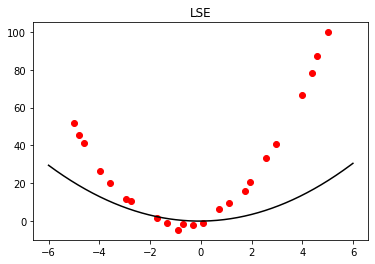

In [47]:
plt.scatter(solve.x, solve.y, color = 'red')
x = np.arange(-6, 6, 0.01)
y = f(x, LSEweights.mat)
plt.plot(x, y, color = 'black')
plt.title('LSE')
plt.show()

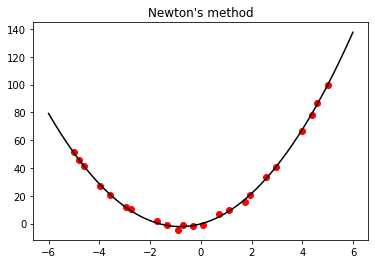

In [48]:
plt.scatter(solve.x, solve.y, color = 'red')
x = np.arange(-6, 6, 0.01)
y = f(x, NewtonWeights.mat)
plt.plot(x, y, color = 'black')
plt.title("Newton's method")
plt.show()